In [5]:
import os
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [7]:
df = pd.read_csv("/content/train.csv")

In [8]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.isnull().sum()

In [ ]:
df.isna().sum()

In [16]:
criteria = [col for col in df.columns[2:]]
print(criteria)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [59]:
 df["toxic"].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [87]:
# df.iloc[:,2:].count()
df.iloc[:,2:].sum().values

array([15294,  1595,  8449,   478,  7877,  1405])

In [74]:
# fakes count
lst_tox = []
for i in range(len(criteria)):
    lst_tox.append(df[df[criteria[i]]==1][criteria[i]].count())

15294
1595
8449
478
7877
1405


In [75]:
#non toxic
lst_nontox =[]
for i in range(len(criteria)):
    lst_nontox.append(df[df[criteria[i]]==0][criteria[i]].count())

144277
157976
151122
159093
151694
158166


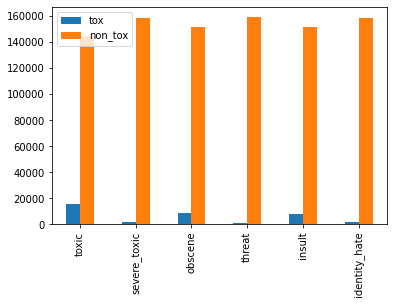

In [82]:
df_counts = pd.DataFrame({'criteria': criteria, 'tox':lst_tox, 'non_tox':lst_nontox}, index=criteria)
df_counts.plot(kind="bar")

In [72]:
df[criteria].corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


In [60]:
n = df[df["toxic"]==1]["toxic"].count()
print(n)

15294


In [144]:
# balancing
df = pd.concat([ df[df["toxic"] == 0].sample(n) , df[df["toxic"] == 1] ])


In [15]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
def preprocess(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words:
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [156]:
df["comment_text_clean"] = df["comment_text"].apply(preprocess)

## simple preprocessing works better than hard using proprocess() function

In [44]:
# simple preprocessing. \n removal
import re
df['comment_text_clean'] = df['comment_text'].apply(lambda x: re.sub(r'\n', '', x))
df['comment_text_clean'] = df['comment_text_clean'].apply(lambda x: re.sub(r'[^\w\s]','',x))
df['comment_text_clean'] = df['comment_text_clean'].apply(str.lower)

### **K-fold validation**


using CountVectorizer

In [48]:
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
folds_train_test_ids = [el for el in skf.split(df, df["toxic"])]

In [184]:
all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    model = Pipeline([
        ("vectorizer", CountVectorizer()),
        ("logistic_reg", LogisticRegression(max_iter=1000))
    ])
    model.fit(df["comment_text_clean"].iloc[train_ids], df["toxic"].iloc[train_ids])

    fold_train_preds = model.predict_proba(df["comment_text_clean"].iloc[train_ids])[:,1]
    fold_test_preds = model.predict_proba(df["comment_text_clean"].iloc[test_ids])[:,1]

    fold_train_targets = df["toxic"].iloc[train_ids].values
    fold_test_targets = df["toxic"].iloc[test_ids].values
    print(
        f"Fold {fold_id}\n"
        f"Train Roc Auc score = {roc_auc_score(fold_train_targets, fold_train_preds)}\n"
        f"Test Roc Auc score = {roc_auc_score(fold_test_targets, fold_test_preds)}"
    )
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(model)

    
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)


print(f"OOF Test Score: {roc_auc_score(all_test_targets, all_test_preds)}")
print(f"OOF Train Score: {roc_auc_score(all_train_targets, all_train_preds)}")

Fold 0
Train Roc Auc score = 0.9989200924745595
Test Roc Auc score = 0.9539359470780651
Fold 1
Train Roc Auc score = 0.9988575320288273
Test Roc Auc score = 0.9559034103301948
Fold 2
Train Roc Auc score = 0.9988715972737273
Test Roc Auc score = 0.9555117450946468
Fold 3
Train Roc Auc score = 0.9989405838560081
Test Roc Auc score = 0.9576020303552694
Fold 4
Train Roc Auc score = 0.9989334432632817
Test Roc Auc score = 0.9522531162267429
OOF Test Score: 0.9550673842937781
OOF Train Score: 0.9989055480980864


In [ ]:
df_test = pd.read_csv("/content/test.csv")
df_test

In [ ]:
df_test['comment_text_clean'] = df_test['comment_text'].apply(lambda x: re.sub(r'\n', '', x))
df_test['comment_text_clean'] = df_test['comment_text_clean'].apply(lambda x: re.sub(r'[^\w\s]','',x))
df_test['comment_text_clean'] = df_test['comment_text_clean'].apply(str.lower)

In [27]:
df_labels = pd.read_csv("/content/test_labels.csv")
df_test = df_test.merge(df_labels, on="id")
df_test = df_test[~(df_test[criteria] == -1).any(axis=1)].reset_index(drop=True)


In [29]:
df = df.iloc[df_test.index]

In [35]:
# df_test = df_test.iloc[df.index]

In [40]:
df_test.to_csv("final_test.csv")

In [ ]:
test_pred = []
for model in all_models:
    fold_test_pred = model.predict_proba(df_test["comment_text_clean"])[:,1]
    print(len(fold_test_pred))
    test_pred.append(fold_test_pred)



In [332]:
y_pred = np.stack(test_pred,axis=0).mean(0)
print("FINAL TESTING")
print("ROC AUC = ",roc_auc_score(df_test["toxic_x"].values,  y_pred))


FINAL TESTING
ROC AUC =  0.9409854811735874


**using TfidfVectorizer**

In [333]:
all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    model = Pipeline([
        ("vectorizer", TfidfVectorizer()),
        ("logistic_reg", LogisticRegression(max_iter=1000))
    ])
    model.fit(df["comment_text_clean"].iloc[train_ids], df["toxic"].iloc[train_ids])

    fold_train_preds = model.predict_proba(df["comment_text_clean"].iloc[train_ids])[:,1]
    fold_test_preds = model.predict_proba(df["comment_text_clean"].iloc[test_ids])[:,1]

    fold_train_targets = df["toxic"].iloc[train_ids].values
    fold_test_targets = df["toxic"].iloc[test_ids].values
    print(
        f"Fold {fold_id}\n"
        f"Train Roc Auc score = {roc_auc_score(fold_train_targets, fold_train_preds)}\n"
        f"Test Roc Auc score = {roc_auc_score(fold_test_targets, fold_test_preds)}"
    )
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(model)

    
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)


print(f"OOF Test Score: {roc_auc_score(all_test_targets, all_test_preds)}")
print(f"OOF Train Score: {roc_auc_score(all_train_targets, all_train_preds)}")

Fold 0
Train Roc Auc score = 0.979987297524019
Test Roc Auc score = 0.9534312706592725
Fold 1
Train Roc Auc score = 0.9797903573744587
Test Roc Auc score = 0.9551889017995336
Fold 2
Train Roc Auc score = 0.9799613381121541
Test Roc Auc score = 0.9585164533061836
Fold 3
Train Roc Auc score = 0.9794416190081643
Test Roc Auc score = 0.9595261470992007
Fold 4
Train Roc Auc score = 0.980157004200058
Test Roc Auc score = 0.9569853701276253
OOF Test Score: 0.9567056034319638
OOF Train Score: 0.9798685278320005


In [ ]:
test_pred = []
for model in all_models:
    fold_test_pred = model.predict_proba(df_test["comment_text_clean"])[:,1]
    test_pred.append(fold_test_pred)



In [335]:
y_pred = np.stack(test_pred,axis=0).mean(0)
print("FINAL TESTING")
print("ROC AUC = ",roc_auc_score(df_test["toxic_x"].values,  y_pred))


FINAL TESTING
ROC AUC =  0.9412737572442317


**using spacy embeddings**

In [ ]:
!python -m spacy download en_core_web_lg


In [361]:
import numpy as np
import spacy
from sklearn.base import BaseEstimator, TransformerMixin

spacy_nlp = spacy.load('en_core_web_lg')
# spacy_doc = spacy_nlp(df['comment_text_clean'][0])

class SpacyEmbeddings(TransformerMixin,BaseEstimator):
    def __init__(self, model=spacy_nlp):
        self.model = model

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        data = list(spacy_nlp(doc).vector.reshape(1,-1) for doc in X)
        return np.concatenate(data)

In [362]:
all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    model = Pipeline([
        ("vectorizer", SpacyEmbeddings()),
        ("logistic_reg", LogisticRegression(max_iter=1000))
    ])
    model.fit(df["comment_text_clean"].iloc[train_ids], df["toxic"].iloc[train_ids])

    fold_train_preds = model.predict_proba(df["comment_text_clean"].iloc[train_ids])[:,1]
    fold_test_preds = model.predict_proba(df["comment_text_clean"].iloc[test_ids])[:,1]

    fold_train_targets = df["toxic"].iloc[train_ids].values
    fold_test_targets = df["toxic"].iloc[test_ids].values
    print(
        f"Fold {fold_id}\n"
        f"Train Roc Auc score = {roc_auc_score(fold_train_targets, fold_train_preds)}\n"
        f"Test Roc Auc score = {roc_auc_score(fold_test_targets, fold_test_preds)}"
    )
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(model)

    
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)


print(f"OOF Test Score: {roc_auc_score(all_test_targets, all_test_preds)}")
print(f"OOF Train Score: {roc_auc_score(all_train_targets, all_train_preds)}")

Fold 0
Train Roc Auc score = 0.958841289025752
Test Roc Auc score = 0.9519674151622642
Fold 1
Train Roc Auc score = 0.9588839757580778
Test Roc Auc score = 0.9519356224180417
Fold 2
Train Roc Auc score = 0.9585358584417104
Test Roc Auc score = 0.9536621554454663
Fold 3
Train Roc Auc score = 0.9581195419386583
Test Roc Auc score = 0.9540216381086936
Fold 4
Train Roc Auc score = 0.9580818951841144
Test Roc Auc score = 0.9554164864488688
OOF Test Score: 0.9533970155485592
OOF Train Score: 0.9584944284624131


In [363]:
test_pred = []
for model in all_models:
    fold_test_pred = model.predict_proba(df_test["comment_text_clean"])[:,1]
    test_pred.append(fold_test_pred)



In [364]:
y_pred = np.stack(test_pred,axis=0).mean(0)
print("FINAL TESTING")
print("ROC AUC = ",roc_auc_score(df_test["toxic_x"].values,  y_pred))


FINAL TESTING
ROC AUC =  0.9387802441424898


**using SentenceTransformer**

In [41]:
import torch


In [42]:
torch.cuda.is_available()


True

In [ ]:
pip install sentence_transformers

In [46]:
from sentence_transformers import SentenceTransformer

sent_tr = SentenceTransformer('all-MiniLM-L6-v2',device="cuda")

train_embs = sent_tr.encode(df["comment_text_clean"].to_list())
test_embs = sent_tr.encode(df_test["comment_text_clean"].to_list())

In [49]:
all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    model = Pipeline([
        ("normalize", StandardScaler()),
        ("logistic_reg", LogisticRegression(max_iter=1000))
    ])
    model.fit(train_embs[train_ids], df["toxic"].iloc[train_ids])

    fold_train_preds = model.predict_proba(train_embs[train_ids])[:,1]
    fold_test_preds = model.predict_proba(train_embs[test_ids])[:,1]

    fold_train_targets = df["toxic"].iloc[train_ids].values
    fold_test_targets = df["toxic"].iloc[test_ids].values
    print(
        f"Fold {fold_id}\n"
        f"Train Roc Auc score = {roc_auc_score(fold_train_targets, fold_train_preds)}\n"
        f"Test Roc Auc score = {roc_auc_score(fold_test_targets, fold_test_preds)}"
    )
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(model)

    
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)


print(f"OOF Test Score: {roc_auc_score(all_test_targets, all_test_preds)}")
print(f"OOF Train Score: {roc_auc_score(all_train_targets, all_train_preds)}")

Fold 0
Train Roc Auc score = 0.9671519712650942
Test Roc Auc score = 0.9545650381931088
Fold 1
Train Roc Auc score = 0.9673400150599927
Test Roc Auc score = 0.952565258009562
Fold 2
Train Roc Auc score = 0.9650569868197583
Test Roc Auc score = 0.9638575039841732
Fold 3
Train Roc Auc score = 0.9658174845909279
Test Roc Auc score = 0.961013809178266
Fold 4
Train Roc Auc score = 0.9666327639602207
Test Roc Auc score = 0.957225905402731
OOF Test Score: 0.957910172953175
OOF Train Score: 0.9664088658288319


In [51]:
test_pred = []
for model in all_models:
    fold_test_pred = model.predict_proba(test_embs)[:,1]
    test_pred.append(fold_test_pred)



In [53]:
y_pred = np.stack(test_pred,axis=0).mean(0)
print("FINAL TESTING")
print("ROC AUC = ",roc_auc_score(df_test["toxic"].values,  y_pred))


FINAL TESTING
ROC AUC =  0.9374485950568481


**using** **w2vec**

In [177]:
import transformers

In [ ]:
# from transformers import GensimWord2VecVectorizer
from gensim.sklearn_api import W2VTransformer

all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    model = Pipeline([
        ("vectorizer", W2VTransformer(size=16698, min_count=5, seed=1)),
        ("logistic_reg", LogisticRegression(max_iter=1000))
    ])
    model.fit(df["comment_text_clean"].iloc[train_ids].apply(str.split), df["toxic"].iloc[train_ids])

    fold_train_preds = model.predict_proba(df["comment_text_clean"].iloc[train_ids])[:,1]
    fold_test_preds = model.predict_proba(df["comment_text_clean"].iloc[test_ids])[:,1]

    fold_train_targets = df["toxic"].iloc[train_ids].values
    fold_test_targets = df["toxic"].iloc[test_ids].values
    print(
        f"Fold {fold_id}\n"
        f"Train Roc Auc score = {roc_auc_score(fold_train_targets, fold_train_preds)}\n"
        f"Test Roc Auc score = {roc_auc_score(fold_test_targets, fold_test_preds)}"
    )
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(model)

    
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)


print(f"OOF Test Score: {roc_auc_score(all_test_targets, all_test_preds)}")
print(f"OOF Train Score: {roc_auc_score(all_train_targets, all_train_preds)}")